In [1]:
%load_ext pycodestyle_magic
%flake8_on --max_line_length 119 --ignore W293,W291

In [9]:
import numpy as np
import fitsio
import meds
import json
import esutil as eu
import galsim

In [10]:
d = fitsio.read("DES2120-4706_metadetect-v4_mdetcat_range0000-0019.fits.fz")

In [11]:
m = meds.MEDS("DES2120-4706_r5581p01_r_pizza-cutter-slices.fits.fz")

In [12]:
einfo = fitsio.read("DES2120-4706_r5581p01_r_pizza-cutter-slices.fits.fz", ext="epochs_info")
iinfo = fitsio.read("DES2120-4706_r5581p01_r_pizza-cutter-slices.fits.fz", ext="image_info")

pcat = m.get_cat()

In [13]:
einfo.dtype.names

('id',
 'image_id',
 'flags',
 'row_start',
 'col_start',
 'box_size',
 'psf_row_start',
 'psf_col_start',
 'psf_box_size',
 'weight')

In [14]:
assert np.array_equal(iinfo["image_id"], np.arange(len(iinfo)))

In [37]:
from esutil.pbar import PBar
import sys

buff = 48
xlen = 2048
ylen = 4096
xmin = buff
xmax = xlen - buff
ymin = buff 
ymax = ylen - buff
dx = 32
dy = 32

nx = (xmax - xmin) // dx
ny = (ymax - ymin) // dy
assert nx * dx == (xmax-xmin)
assert ny * dy == (ymax-ymin)
print("# of (y, x) bins:", (ny, nx))


def _get_ccd_num(pth):
    return pth.split("/")[1].split("_")[2][1:]


def _get_bin_locs(gs_wcs, ra, dec, msk):
    # compute the bin locations for the objects
    x, y = gs_wcs.radecToxy(ra, dec, units="degrese")
    x -= 1
    y -= 1
    # print(x.min(), x.max(), y.min(), y.max())
    
    # the factor of 0.5 is here because the first pixel 
    # starts at -0.5 in 0 indexed pixel-centered coords
    xind = np.floor((x-xmin + 0.5)/dx).astype(int)
    yind = np.floor((y-ymin + 0.5)/dy).astype(int)
    
    # cut points outside the array
    msk_c = np.where(
        (xind >= 0)
        & (xind < nx)
        & (yind >= 0)
        & (yind < ny)
    )[0]
    if len(msk_c) == 0:
        return None

    msk = msk[msk_c]
    xind = xind[msk_c]
    yind = yind[msk_c]
    # print(xind.min(), xind.max(), yind.min(), yind.max())
    
    return xind, yind, msk
    

def _accum_shear(ccdres, ccdnum, cname, shear, mdet_step, xind, yind, g):
    msk_s = mdet_step == shear
    ccdres[ccdnum][cname] = np.zeros((ny, nx))
    ccdres[ccdnum]["num_" + cname] = np.zeros((ny, nx))
    if np.any(msk_s):
        # see https://numpy.org/doc/stable/reference/generated/numpy.ufunc.at.html#numpy.ufunc.at
        np.add.at(
            ccdres[ccdnum][cname], 
            (yind[msk_s], xind[msk_s]), 
            g[msk_s],
        )
        np.add.at(
            ccdres[ccdnum]["num_" + cname], 
            (yind[msk_s], xind[msk_s]), 
            np.ones_like(g[msk_s]),
        )


ccdres = {}
for image_id in PBar(np.arange(1, len(iinfo)), file=sys.stdout):
    # get all slices that used this SE image
    msk = (
        (einfo["flags"] == 0) 
        & (einfo["image_id"] == image_id)
        & (einfo["weight"] > 0)
    )
    if not np.any(msk):
        # if nothing move on
        continue
    unique_slices = np.unique(einfo["id"][msk])

    # find all detections that used this slice
    msk_d = np.where(np.in1d(d["slice_id"], unique_slices))[0]
    if len(msk_d) == 0:
        # if nothing move on
        continue
    
    # now construct the WCS and other metadata
    gs_wcs = galsim.FitsWCS(header=json.loads(iinfo['wcs'][image_id]))    
    ccdnum = _get_ccd_num(iinfo['image_path'][image_id])
    
    ind_res = _get_bin_locs(gs_wcs, d["ra"][msk_d], d["dec"][msk_d], msk_d)
    if ind_res is None:
        continue
    xind, yind, msk_d = ind_res
    
    ccdres[ccdnum] = {}
    mdet_step = d["mdet_step"][msk_d]
    _accum_shear(ccdres, ccdnum, "g1", "noshear", mdet_step, xind, yind, d["mdet_g_1"][msk_d])
    _accum_shear(ccdres, ccdnum, "g2", "noshear", mdet_step, xind, yind, d["mdet_g_2"][msk_d])
    _accum_shear(ccdres, ccdnum, "g1p", "1p", mdet_step, xind, yind, d["mdet_g_1"][msk_d])
    _accum_shear(ccdres, ccdnum, "g1m", "1m", mdet_step, xind, yind, d["mdet_g_1"][msk_d])
    _accum_shear(ccdres, ccdnum, "g2p", "2p", mdet_step, xind, yind, d["mdet_g_2"][msk_d])
    _accum_shear(ccdres, ccdnum, "g2m", "2m", mdet_step, xind, yind, d["mdet_g_2"][msk_d])

# of (y, x) bins: (125, 61)
|####################| 158/158 100% [elapsed: 00:00 left: 00:00]


In [17]:
import proplot as pplt

/var/folders/5w/65hhf7d16cvbrv_wsj7y1_nm0000gn/T/ipykernel_35040/2760678376.py:2: RuntimeWarning: invalid value encountered in true_divide
  g1 = ccdres[ccdnum]["g1"] / ccdres[ccdnum]["num_g1"]
/var/folders/5w/65hhf7d16cvbrv_wsj7y1_nm0000gn/T/ipykernel_35040/2760678376.py:3: RuntimeWarning: invalid value encountered in true_divide
  g1p = ccdres[ccdnum]["g1p"] / ccdres[ccdnum]["num_g1p"]
/var/folders/5w/65hhf7d16cvbrv_wsj7y1_nm0000gn/T/ipykernel_35040/2760678376.py:4: RuntimeWarning: invalid value encountered in true_divide
  g1m = ccdres[ccdnum]["g1m"] / ccdres[ccdnum]["num_g1m"]
/var/folders/5w/65hhf7d16cvbrv_wsj7y1_nm0000gn/T/ipykernel_35040/2760678376.py:7: RuntimeWarning: invalid value encountered in true_divide
  g2 = ccdres[ccdnum]["g2"] / ccdres[ccdnum]["num_g2"]
/var/folders/5w/65hhf7d16cvbrv_wsj7y1_nm0000gn/T/ipykernel_35040/2760678376.py:8: RuntimeWarning: invalid value encountered in true_divide
  g2p = ccdres[ccdnum]["g2p"] / ccdres[ccdnum]["num_g2p"]
/var/folders/5w/65hhf

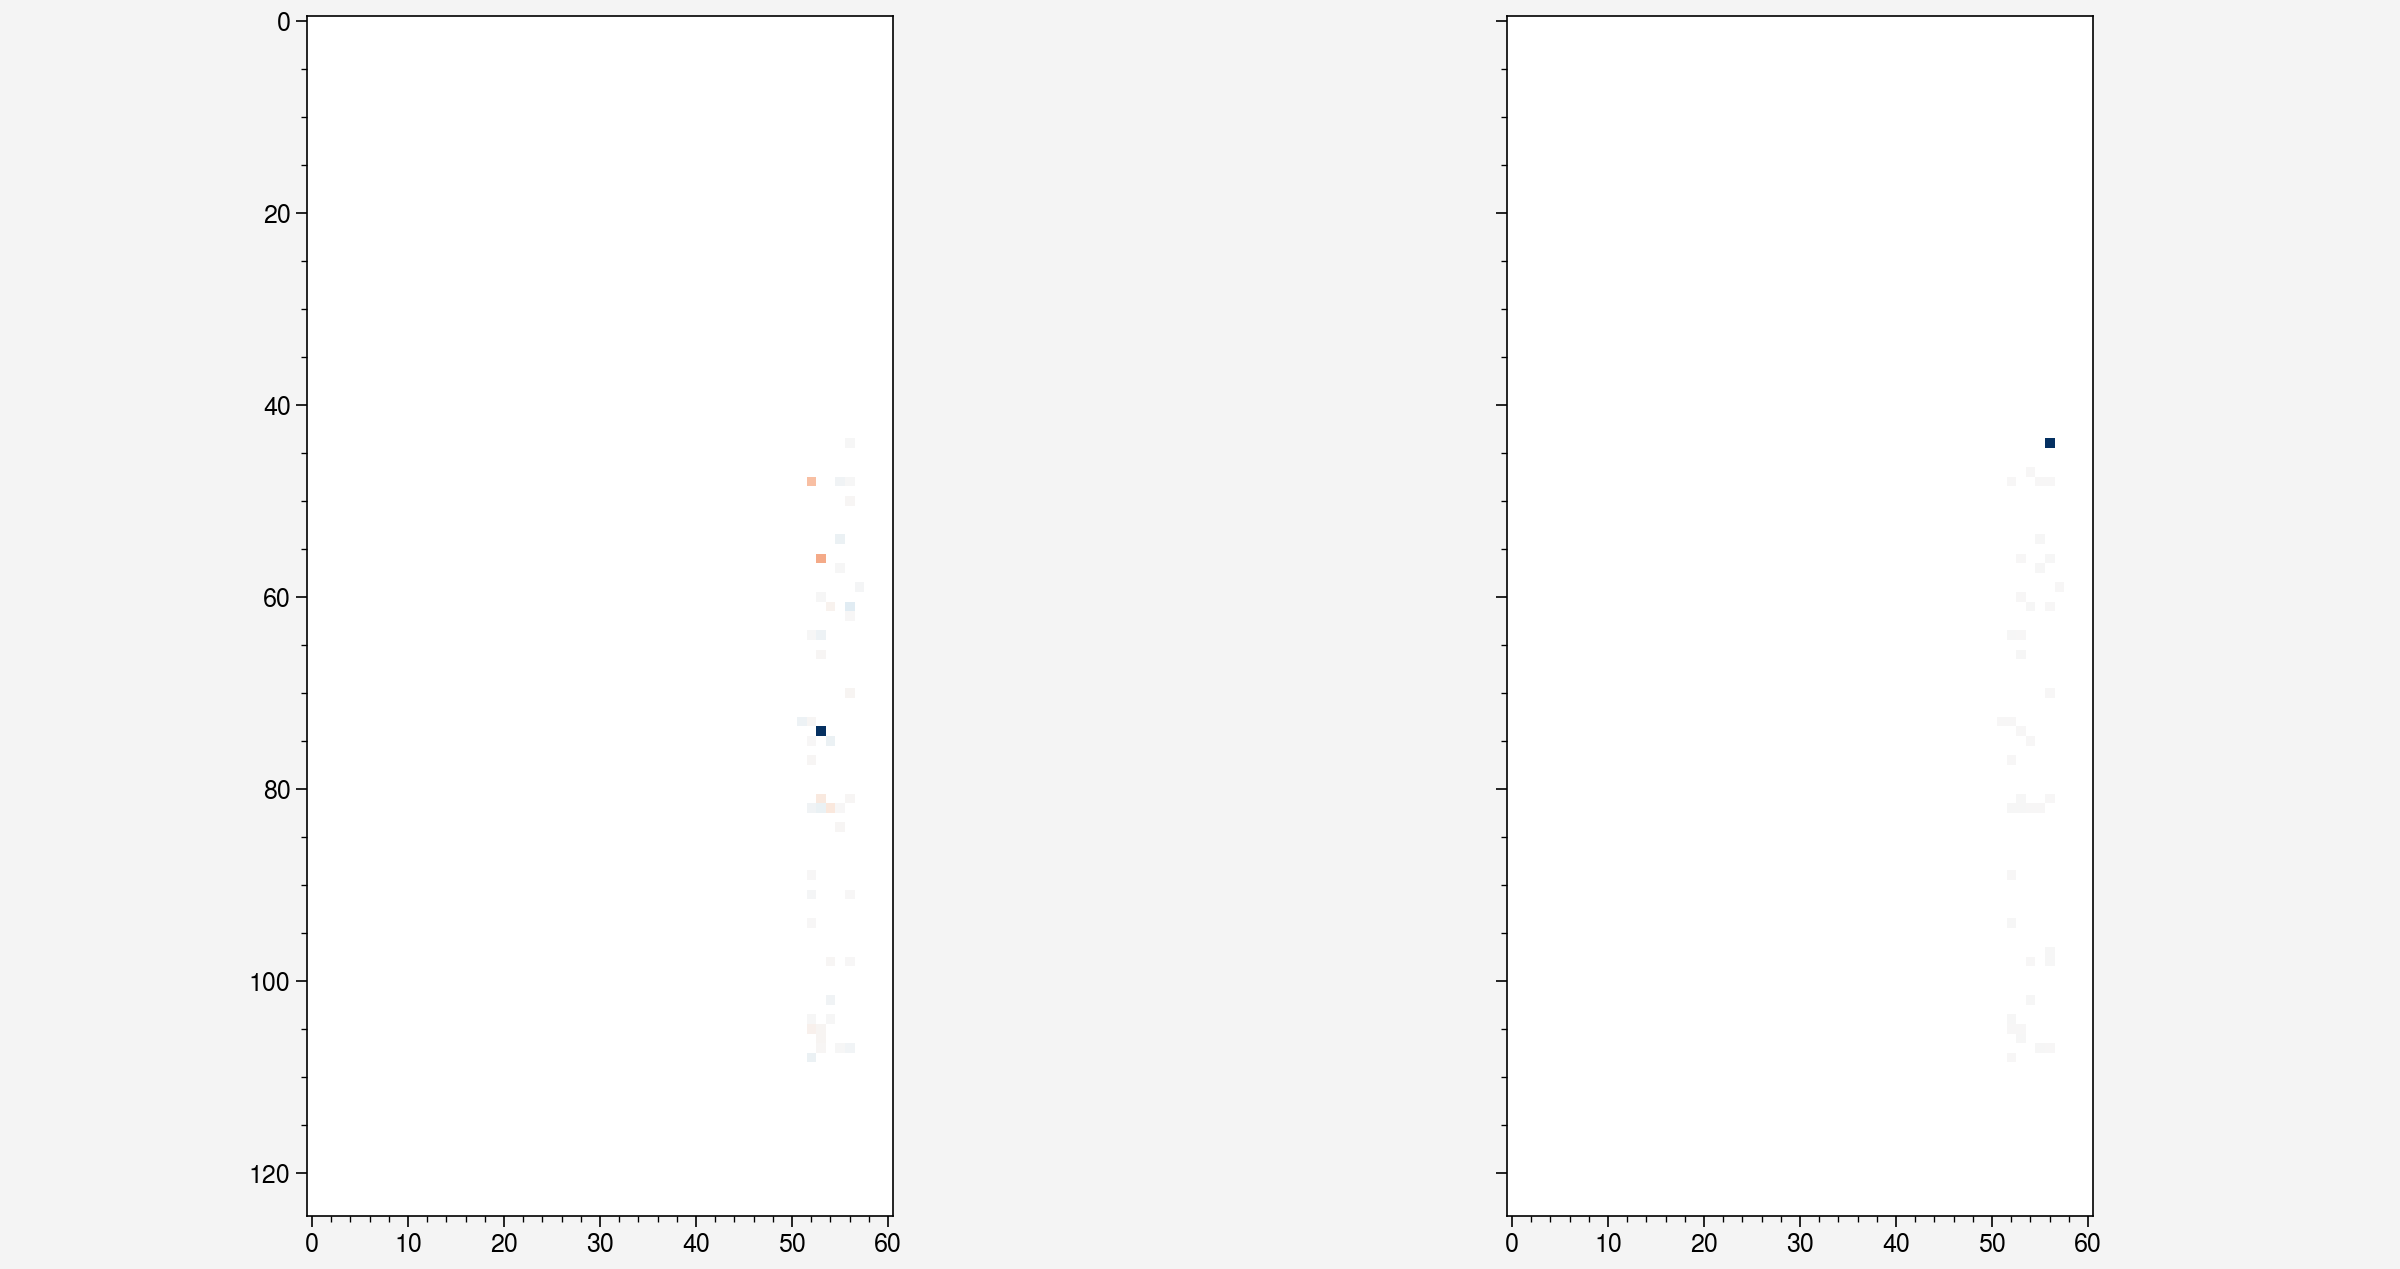

In [33]:
def _compute_g1_g2(ccdres, ccdnum):
    g1 = ccdres[ccdnum]["g1"] / ccdres[ccdnum]["num_g1"]
    g1p = ccdres[ccdnum]["g1p"] / ccdres[ccdnum]["num_g1p"]
    g1m = ccdres[ccdnum]["g1m"] / ccdres[ccdnum]["num_g1m"]
    R11 = (g1p - g1m) / 2 / 0.01

    g2 = ccdres[ccdnum]["g2"] / ccdres[ccdnum]["num_g2"]
    g2p = ccdres[ccdnum]["g2p"] / ccdres[ccdnum]["num_g2p"]
    g2m = ccdres[ccdnum]["g2m"] / ccdres[ccdnum]["num_g2m"]
    R22 = (g2p - g2m) / 2 / 0.01
    
    return g1/R11, g2/R22


ccdnum = list(ccdres)[0]
g1, g2 = _compute_g1_g2(ccdres, ccdnum)

fig, axs = pplt.subplots(refaspect=1, refwidth=6, ncols=2)
axs[0].imshow(g1)
axs[0].grid(False)

axs[1].imshow(g2)
axs[1].grid(False)